# Метод k ближайших соседей (kNN): классификация и регрессия

В этом ноутбуке мы подробно разберём **метод k ближайших соседей (k-Nearest Neighbors, kNN)**:

- интуитивная идея метода и его ключевые свойства;
- kNN **для классификации** на простом двумерном примере с визуализацией границ решений;
- влияние параметра $k$ (числа соседей) на модель;
- использование kNN из `sklearn` и оценка качества на train/test split;
- kNN **для регрессии** на примере однофакторной функции;
- важные практические моменты: масштабирование признаков, выбор метрики расстояния, достоинства и ограничения метода.

kNN — это классический пример **ленивого (lazy) метода обучения**: модель почти ничего не запоминает на этапе обучения, а все вычисления происходят при предсказании, исходя из расстояний до объектов обучающей выборки.

## 1. Импорт библиотек и генерация данных

Сначала импортируем необходимые библиотеки и сгенерируем игрушечный двумерный датасет для задачи классификации.
На нём удобно визуализировать работу kNN и границы решений.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.1. Игрушечный датасет для классификации

Используем функцию `make_moons`, которая генерирует два класса в виде полуокружностей. Это неквадратно разделимый датасет (его нельзя разделить одной прямой), поэтому он хорошо подходит для демонстрации нелинейных моделей, в том числе kNN.

In [2]:
X_cls, y_cls = make_moons(n_samples=500, noise=0.2, random_state=RANDOM_STATE)

print('Форма X_cls:', X_cls.shape)
print('Форма y_cls:', y_cls.shape)

Форма X_cls: (500, 2)
Форма y_cls: (500,)


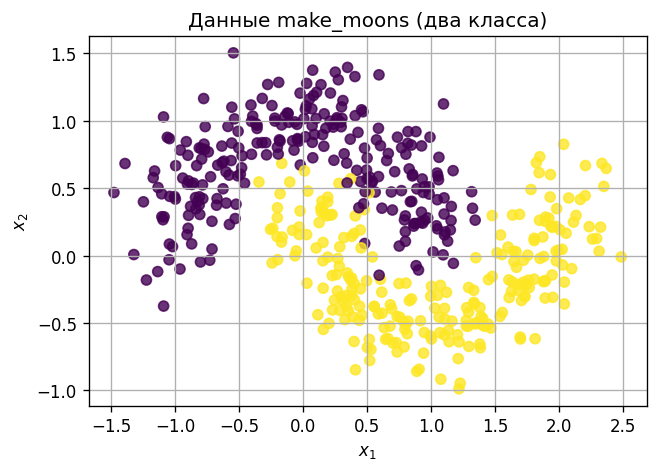

In [3]:
plt.figure()
plt.scatter(X_cls[:, 0], X_cls[:, 1], c=y_cls, alpha=0.8)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Данные make_moons (два класса)')
plt.grid(True)
plt.show()

## 2. Интуиция метода k ближайших соседей

Идея kNN проста и интуитивна:

1. У нас есть обучающая выборка $\{(x_i, y_i)\}_{i=1}^N$.
2. Чтобы сделать предсказание для нового объекта $x$:
   - находим **k ближайших** объектов из обучающей выборки по некоторой метрике расстояния (обычно евклидовой);
   - смотрим их ответы $y_{(1)}, \dots, y_{(k)}$;
   - для **классификации**: берём **большинство классов** среди соседей (majority vote);
   - для **регрессии**: берём, например, **среднее значение** целевой переменной среди соседей.

Формально, для классификации при заданном $k$ и метрике $d(\cdot, \cdot)$ предсказание можно записать так:

1. Пусть $N_k(x)$ — множество индексов k ближайших соседей точки $x$.
2. Тогда предсказанный класс

$$
\hat{y}(x) = \underset{c}{\arg\max} \sum_{i \in N_k(x)} \mathbf{1}(y_i = c).
$$

Для регрессии:

$$
\hat{y}(x) = \frac{1}{k} \sum_{i \in N_k(x)} y_i.
$$

Особенности kNN:

- **Нет явного обучения**: модель просто хранит все обучающие точки.
- Решение сильно зависит от **выбора метрики расстояния** и **выбора $k$**.
- Предсказание для нового объекта может быть дорогим по времени: нужно найти ближайших соседей среди всех обучающих точек.

## 3. Ручная реализация kNN для классификации (2D-пример)

Чтобы лучше понять механику алгоритма, реализуем упрощённую версию kNN классификатора вручную. Она будет работать только для небольших датасетов (потому что мы будем честно считать расстояния до всех точек), но отлично подходит для иллюстрации.

In [4]:
def knn_predict_one(x, X_train, y_train, k=5):
    """Предсказание класса для одной точки x с помощью простого kNN.

    Параметры:
    - x: вектор признаков формы (d,),
    - X_train: матрица обучающих признаков формы (N, d),
    - y_train: вектор меток классов формы (N,),
    - k: число ближайших соседей.
    """
    # Вычисляем евклидовы расстояния от x до всех обучающих точек
    distances = np.linalg.norm(X_train - x, axis=1)
    
    # Индексы k ближайших соседей
    neighbor_idxs = np.argsort(distances)[:k]
    neighbor_labels = y_train[neighbor_idxs]
    
    # Голосование по классам
    values, counts = np.unique(neighbor_labels, return_counts=True)
    # Берём класс с максимальным числом голосов
    majority_class = values[np.argmax(counts)]
    return majority_class


def knn_predict(X, X_train, y_train, k=5):
    """Предсказание классов для набора точек X с помощью простого kNN."""
    return np.array([knn_predict_one(x, X_train, y_train, k=k) for x in X])

Проверим, что наша функция работает на небольшом наборе точек и даёт предсказания.

In [5]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

y_pred_small = knn_predict(X_test_small[:10], X_train_small, y_train_small, k=5)

print('Истинные метки:   ', y_test_small[:10])
print('Предсказанные kNN:', y_pred_small)

Истинные метки:    [1 0 0 1 1 1 1 0 0 0]
Предсказанные kNN: [1 0 0 1 1 1 1 0 0 0]


## 4. Визуализация границ решений kNN при разных k

Теперь посмотрим, как параметр $k$ влияет на форму границ решений. Для этого будем строить карту предсказаний kNN на сетке по всему пространству признаков и сравнивать её с исходными точками.

Схема:

1. Обучаем kNN на всём датасете `make_moons`.
2. Строим равномерную сетку точек в пределах данных.
3. Для каждой точки сетки вычисляем предсказанный класс.
4. Рисуем фон (решётка) в цветах предсказанных классов и поверх — исходные точки.

Сделаем это для $k=1$, $k=5$ и $k=20$.

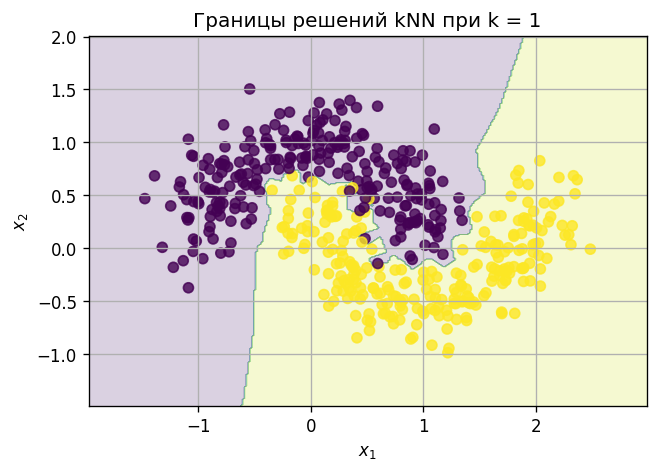

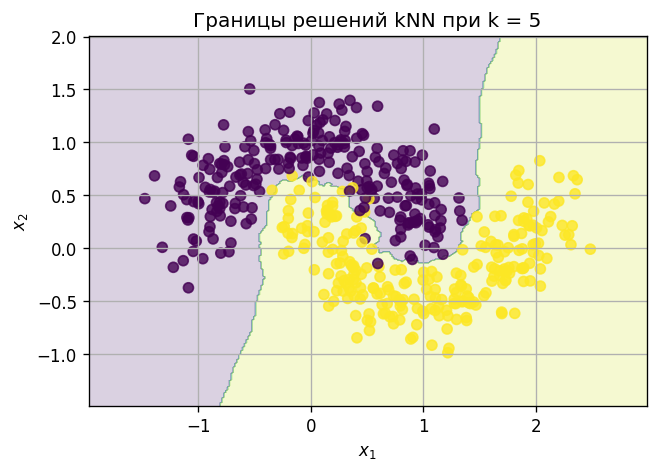

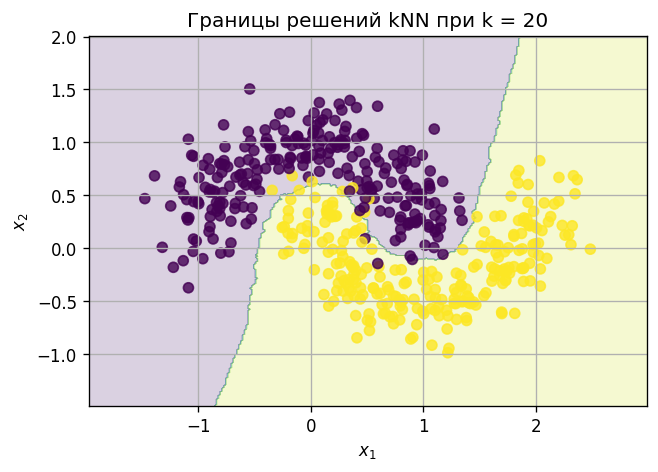

In [6]:
def plot_knn_decision_boundary(X, y, k):
    # Строим сетку
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Предсказания (используем нашу простую реализацию)
    Z = knn_predict(grid, X, y, k=k)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(f'Границы решений kNN при k = {k}')
    plt.grid(True)
    plt.show()


for k in [1, 5, 20]:
    plot_knn_decision_boundary(X_cls, y_cls, k=k)

Наблюдения:

- При $k=1$ границы решений очень **зубчатые и фрагментированные** — модель подстраивается под каждый шумовой объект, фактически запоминая обучающую выборку. Это пример **переобучения**.
- При увеличении $k$ границы становятся **более гладкими**: модель учитывает больше соседей и усредняет шум.
- При слишком большом $k$ (например, когда $k$ сопоставим с числом объектов) модель может стать слишком грубой и не различать детали структуры данных (пример недообучения).

## 5. kNN из `sklearn` и влияние k на качество классификации

Теперь воспользуемся реализацией `KNeighborsClassifier` из `sklearn` и посмотрим, как меняется точность на тестовой выборке при различном числе соседей $k$.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=RANDOM_STATE, stratify=y_cls
)

print('Размер обучения:', X_train.shape[0])
print('Размер теста:', X_test.shape[0])

Размер обучения: 350
Размер теста: 150


In [8]:
k_values = list(range(1, 31))
acc_values = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_values.append(acc)

for k, acc in zip(k_values, acc_values):
    print(f'k = {k:2d}, accuracy = {acc:.3f}')

k =  1, accuracy = 0.940
k =  2, accuracy = 0.967
k =  3, accuracy = 0.973
k =  4, accuracy = 0.980
k =  5, accuracy = 0.987
k =  6, accuracy = 0.980
k =  7, accuracy = 0.987
k =  8, accuracy = 0.987
k =  9, accuracy = 0.987
k = 10, accuracy = 0.987
k = 11, accuracy = 0.993
k = 12, accuracy = 0.993
k = 13, accuracy = 0.987
k = 14, accuracy = 0.987
k = 15, accuracy = 0.980
k = 16, accuracy = 0.987
k = 17, accuracy = 0.987
k = 18, accuracy = 0.993
k = 19, accuracy = 0.987
k = 20, accuracy = 0.987
k = 21, accuracy = 0.987
k = 22, accuracy = 0.980
k = 23, accuracy = 0.987
k = 24, accuracy = 0.980
k = 25, accuracy = 0.987
k = 26, accuracy = 0.987
k = 27, accuracy = 0.980
k = 28, accuracy = 0.987
k = 29, accuracy = 0.993
k = 30, accuracy = 0.993


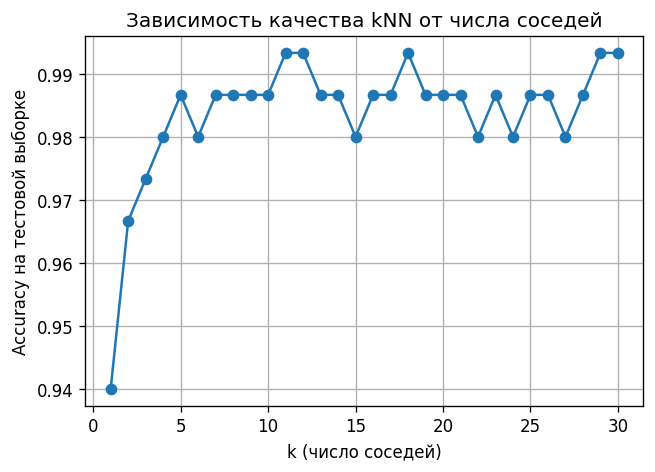

In [9]:
plt.figure()
plt.plot(k_values, acc_values, marker='o')
plt.xlabel('k (число соседей)')
plt.ylabel('Accuracy на тестовой выборке')
plt.title('Зависимость качества kNN от числа соседей')
plt.grid(True)
plt.show()

По графику можно обсудить:

- при слишком малых $k$ модель переобучается и качество может быть нестабильным;
- при увеличении $k$ качество растёт, но затем может начать падать, если модель становится слишком грубой;
- разумный выбор $k$ обычно делают либо по валидационной выборке, либо по кросс-валидации.

## 6. Важность масштабирования признаков

kNN основан на расстояниях между точками. Если один признак измеряется в больших единицах (например, от 0 до 10 000), а другой — в маленьких (от 0 до 1), то **большой по масштабу признак будет доминировать в расстоянии** и фактически "перекрывать" влияние остальных.

Поэтому перед использованием kNN почти всегда рекомендуется выполнять **масштабирование признаков** — например, с помощью `StandardScaler`, который приводит каждый признак к нулевому среднему и единичному стандартному отклонению.

In [10]:
# Для примера просто покажем, как применять StandardScaler для kNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_raw = KNeighborsClassifier(n_neighbors=10)
model_raw.fit(X_train, y_train)
acc_raw = accuracy_score(y_test, model_raw.predict(X_test))

model_scaled = KNeighborsClassifier(n_neighbors=10)
model_scaled.fit(X_train_scaled, y_train)
acc_scaled = accuracy_score(y_test, model_scaled.predict(X_test_scaled))

print(f'Accuracy без масштабирования: {acc_raw:.3f}')
print(f'Accuracy с StandardScaler:    {acc_scaled:.3f}')

Accuracy без масштабирования: 0.987
Accuracy с StandardScaler:    0.980


На этом конкретном игрушечном датасете признаки уже имеют сопоставимый масштаб, поэтому разница может быть небольшой. Однако на реальных данных с признаками разных порядков величин масштабирование **критично** для корректной работы kNN.

## 7. kNN для регрессии

Теперь рассмотрим kNN в задаче регрессии. Принцип тот же, но вместо голосования по классам мы усредняем значения целевой переменной у ближайших соседей.

Сгенерируем одномерный датасет по функции

$$
y = \sin(x) + \varepsilon,
$$

где $\varepsilon$ — случайный шум. Затем сравним предсказания kNN-регрессора при разных значениях $k$.

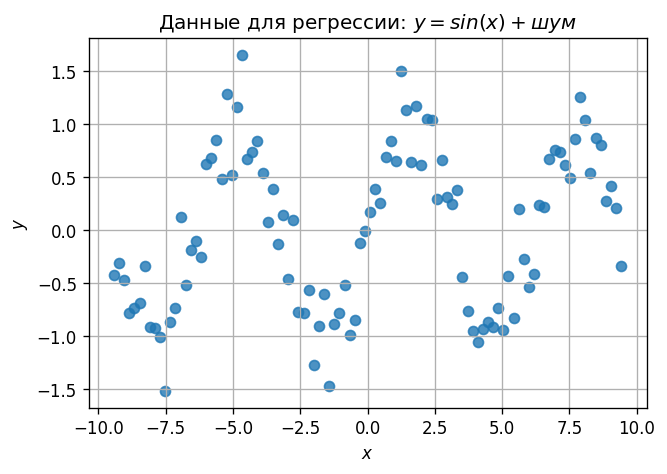

In [14]:
# Генерируем данные для регрессии
n_samples_reg = 100
X_reg = np.linspace(-3 * np.pi, 3 * np.pi, n_samples_reg).reshape(-1, 1)
noise = 0.3 * np.random.randn(n_samples_reg)
y_reg = np.sin(X_reg[:, 0]) + noise

plt.figure()
plt.scatter(X_reg[:, 0], y_reg, alpha=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Данные для регрессии: $y = sin(x) + шум$')
plt.grid(True)
plt.show()

Обучим `KNeighborsRegressor` и посмотрим, как меняется форма аппроксимации при разных $k$.

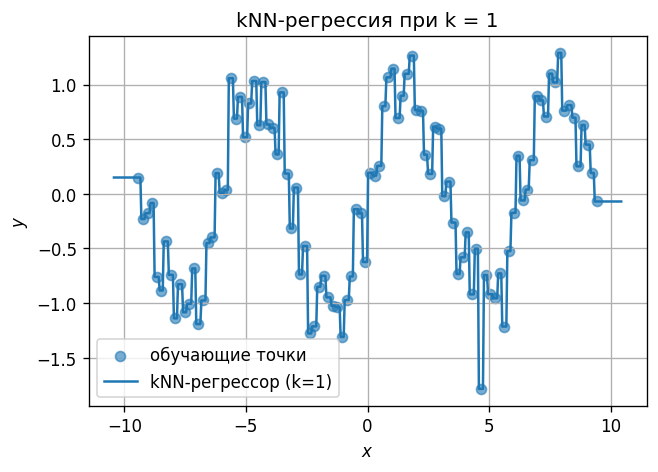

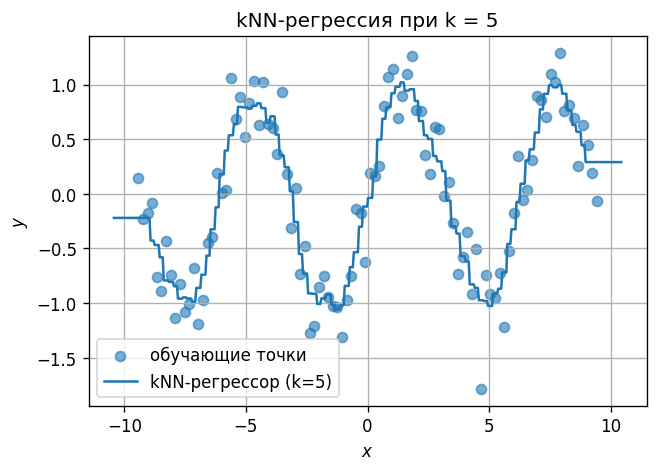

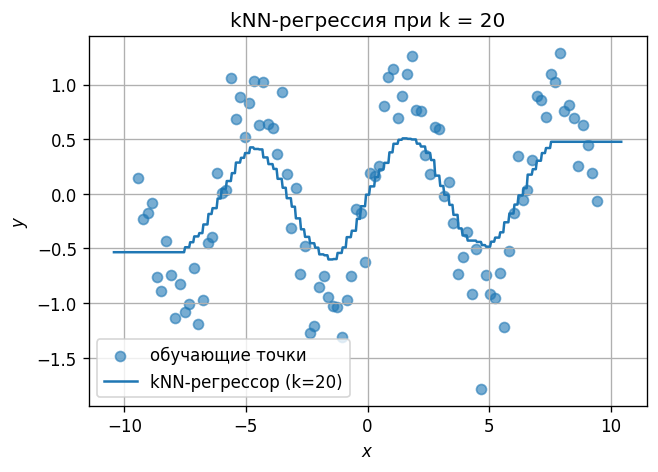

In [12]:
def plot_knn_regression(X, y, k):
    # Обучаем модель
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X, y)

    # Строим плотную сетку по x для визуализации
    X_grid = np.linspace(X.min() - 1.0, X.max() + 1.0, 500).reshape(-1, 1)
    y_pred = model.predict(X_grid)

    plt.figure()
    plt.scatter(X[:, 0], y, alpha=0.6, label='обучающие точки')
    plt.plot(X_grid[:, 0], y_pred, label=f'kNN-регрессор (k={k})')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'kNN-регрессия при k = {k}')
    plt.grid(True)
    plt.legend()
    plt.show()


for k in [1, 5, 20]:
    plot_knn_regression(X_reg, y_reg, k=k)

Наблюдения:

- При $k=1$ кривая буквально проходит через все точки — это сильное переобучение, модель повторяет шум.
- При умеренных $k$ (например, $k=5$) мы получаем гладкую аппроксимацию функции $\sin(x)$.
- При слишком большом $k$ кривая становится чрезмерно сглаженной и может не улавливать форму функции — пример недообучения.

### 7.1. Ошибка регрессии в зависимости от k

Посмотрим, как среднеквадратичная ошибка (MSE) на тестовой выборке меняется при разном $k$.

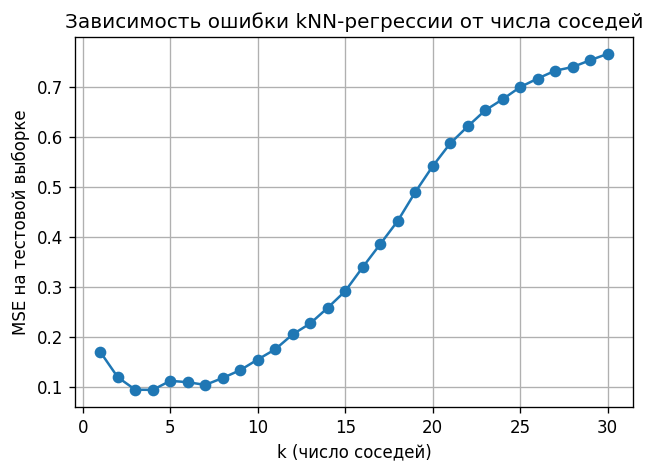

In [13]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=RANDOM_STATE
)

k_values_reg = list(range(1, 31))
mse_values = []

for k in k_values_reg:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    mse_values.append(mse)

plt.figure()
plt.plot(k_values_reg, mse_values, marker='o')
plt.xlabel('k (число соседей)')
plt.ylabel('MSE на тестовой выборке')
plt.title('Зависимость ошибки kNN-регрессии от числа соседей')
plt.grid(True)
plt.show()

Как и в классификации, для регрессии:

- малые значения $k$ приводят к переобучению и высокой вариативности модели;
- большие значения $k$ — к избыточному сглаживанию и потере деталей;
- оптимальный диапазон $k$ подбирается по валидации или кросс-валидации.

## 8. Практические замечания: метрика, размерность, плюсы и минусы

### 8.1. Метрика расстояния

В kNN можно использовать разные метрики расстояния:

- евклидова метрика ($L_2$);
- манхэттенская метрика ($L_1$);
- косинусное расстояние и др.

Выбор метрики зависит от природы признаков. В `sklearn` метрику можно задать параметром `metric` в `KNeighborsClassifier` или `KNeighborsRegressor`.

### 8.2. Проклятие размерности

В высоких размерностях (десятки и сотни признаков) расстояния между точками становятся менее информативными:

- все точки оказываются примерно "одинаково далеко" друг от друга;
- ближайший и дальний соседи по расстоянию могут отличаться не так сильно.

Это явление называют **проклятием размерности**. В таких условиях kNN работает хуже, и разумно:

- делать предварительное понижение размерности (например, PCA);
- внимательно отбирать и конструировать признаки.

### 8.3. Вычислительная сложность

- Обучение kNN тривиально: нужно лишь сохранить обучающие данные.
- Предсказание для нового объекта требует поиска ближайших соседей среди всех обучающих точек. Наивная реализация имеет сложность порядка $O(Nd)$ на один объект, где $N$ — число обучающих точек, $d$ — размерность.

Для ускорения поиска соседей используют структуры данных вроде **k-d деревьев** и **ball-tree**, что частично уменьшает сложность для умеренных размерностей.

### 8.4. Плюсы и минусы kNN

**Плюсы:**

- простая и интуитивно понятная идея;
- нет фазы сложного обучения, легко дообучить на новых данных (можно просто добавить их в память);
- хорошо работает на задачах с несложной структурой и небольшим числом признаков.

**Минусы:**

- медленный предикт на больших выборках (поиск соседей);
- чувствительность к масштабу признаков и выбору метрики расстояния;
- деградация качества в высоких размерностях (проклятие размерности);
- выбор оптимального $k$ требует настройки по валидации.

Несмотря на ограничения, kNN остаётся важным базовым методом и хорошей отправной точкой для понимания идей про **соседство и расстояния**, которые лежат в основе многих более продвинутых алгоритмов (в том числе UMAP, где граф ближайших соседей — ключевой элемент).

## 9. kNN + PCA на более сложном датасете: рукописные цифры

В качестве примера рассмотрим датасет `digits`:

- 64 признака (яркости пикселей $8 \times 8$)
- 10 классов (цифры от 0 до 9)

PCA часто используется в **двух разных ролях**, и важно их не путать:

1. **Для визуализации** (главная цель здесь):
   - Исходные данные (например, `digits`) живут в пространстве высокой размерности
     (64 признака = пиксели $8 \times 8$).
   - Нарисовать границы решений kNN в таком пространстве нельзя, поэтому мы
     сжимаем данные до 2 компонент с помощью PCA и получаем **2D-координаты**.
   - В этих координатах можно:
     - нарисовать точки (объекты) разных классов;
     - нарисовать фон с границами решений модели.
   - При этом **сама модель kNN обучается в исходном пространстве признаков**
     (после масштабирования), а PCA используется только для того, чтобы
     унести всё в двумерную плоскость и сделать картинку.

2. **Как возможный шаг препроцессинга (необязательно в этом ноутбуке)**:
   - В задачах с очень высокой размерностью PCA иногда используют для:
     - уменьшения размерности (быстрее поиск ближайших соседей, меньше шума),
     - улучшения численной устойчивости.
   - Тогда kNN обучается уже на, скажем, первых 20–50 главных компонентах.
   - Это уже **изменяет саму модель** (она видит только сжатые признаки), и качество
     может как улучшиться (меньше шума), так и ухудшиться (теряется часть информации).

В текущем примере основной упор — на первый сценарий:

- kNN обучается на **масштабированных исходных признаках**;
- PCA до 2 компонент нужен, чтобы **построить понятную визуализацию**
  (точек и границ решений) в двумерном пространстве.


In [30]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Загружаем датасет digits
digits = load_digits()
X_digits = digits.data      # (n_samples, 64)
y_digits = digits.target    # 10 классов

print("Форма X_digits:", X_digits.shape)
print("Классы:", np.unique(y_digits))

# 2. train / test split
Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    X_digits, y_digits,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y_digits,
)

# 3. Масштабирование признаков для kNN
scaler_digits = StandardScaler()
Xd_train_scaled = scaler_digits.fit_transform(Xd_train)
Xd_test_scaled = scaler_digits.transform(Xd_test)

# 4. Обучаем kNN В ИСХОДНОМ ПРОСТРАНСТВЕ (64 признака)
k_digits = 7
knn_digits = KNeighborsClassifier(n_neighbors=k_digits)
knn_digits.fit(Xd_train_scaled, yd_train)

yd_pred = knn_digits.predict(Xd_test_scaled)
r = classification_report(yd_test, yd_pred)
print(r)

# 5. Подготовка данных для визуализации: PCA до 2 компонент
#    PCA учим на всех данных (train+test), но уже ПОСЛЕ масштабирования
X_digits_scaled_all = scaler_digits.transform(X_digits)
pca_digits = PCA(n_components=2, random_state=RANDOM_STATE)
X_digits_pca2 = pca_digits.fit_transform(X_digits_scaled_all)

print("Форма X_digits_pca2:", X_digits_pca2.shape)


Форма X_digits: (1797, 64)
Классы: [0 1 2 3 4 5 6 7 8 9]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.93      1.00      0.96        55
           2       0.96      1.00      0.98        53
           3       0.98      0.98      0.98        55
           4       0.98      0.93      0.95        54
           5       0.98      0.95      0.96        55
           6       0.98      0.98      0.98        54
           7       0.95      0.98      0.96        54
           8       0.98      0.90      0.94        52
           9       0.95      0.96      0.95        54

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540

Форма X_digits_pca2: (1797, 2)


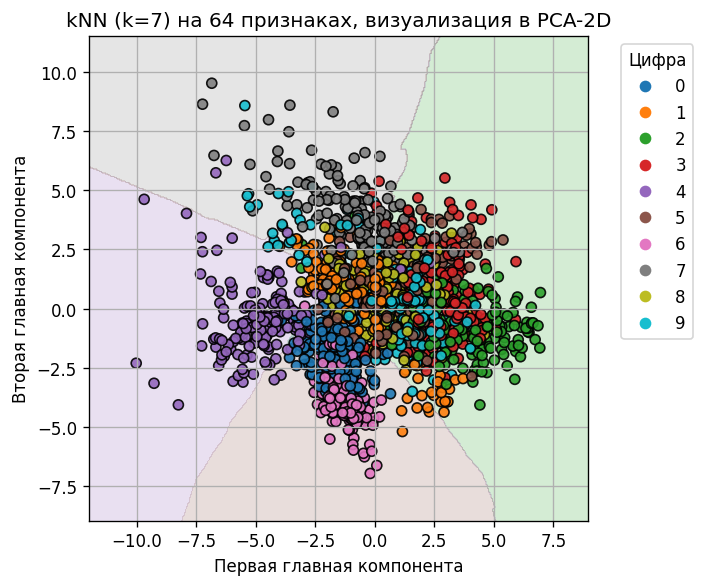

In [28]:
def plot_knn_decision_boundary_pca_highdim(
    X_all, y_all,
    X_all_pca2,
    scaler, pca, model,
    title=""
):
    """
    Визуализация границ решений kNN, обученного в исходном высокоразмерном пространстве,
    в плоскости первых двух главных компонент.

    X_all        : исходные признаки (N, d) ДО масштабирования
    y_all        : метки классов (N,)
    X_all_pca2   : координаты тех же объектов после StandardScaler+PCA, форма (N, 2)
    scaler       : обученный StandardScaler
    pca          : обученный PCA(n_components=2)
    model        : обученный KNeighborsClassifier, обученный на масштабированных исходных признаках
    """
    # Границы по PCA-координатам
    x_min, x_max = X_all_pca2[:, 0].min() - 2.0, X_all_pca2[:, 0].max() + 2.0
    y_min, y_max = X_all_pca2[:, 1].min() - 2.0, X_all_pca2[:, 1].max() + 2.0

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400),
    )
    grid_pca2 = np.c_[xx.ravel(), yy.ravel()]  # точки в 2D PCA-пространстве

    # 1) Переводим точки сетки обратно в 64-мерное масштабированное пространство через inverse_transform PCA
    grid_scaled_approx = pca.inverse_transform(grid_pca2)  # (N_grid, 64)

    # 2) Предсказываем классы kNN, обученным на scaled-признаках
    Z = model.predict(grid_scaled_approx)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    # фон — предсказанные классы
    plt.contourf(xx, yy, Z, alpha=0.2, cmap="tab10")

    # точки — реальные объекты в PCA-пространстве
    plt.scatter(
        X_all_pca2[:, 0], X_all_pca2[:, 1],
        c=y_all, edgecolor="k", alpha=0.9, cmap="tab10"
    )

    plt.xlabel("Первая главная компонента")
    plt.ylabel("Вторая главная компонента")
    plt.title(title)
    plt.grid(True)

    # легенда по цифрам
    classes = np.unique(y_all)
    handles = []
    for cls in classes:
        color = plt.cm.tab10(cls / max(classes))
        handle = plt.Line2D(
            [], [], marker="o", linestyle="",
            color=color, label=str(cls)
        )
        handles.append(handle)
    plt.legend(handles=handles, title="Цифра", bbox_to_anchor=(1.05, 1.0), loc="upper left")

    plt.tight_layout()
    plt.show()


# Вызываем визуализацию
plot_knn_decision_boundary_pca_highdim(
    X_all=X_digits,
    y_all=y_digits,
    X_all_pca2=X_digits_pca2,
    scaler=scaler_digits,
    pca=pca_digits,
    model=knn_digits,
    title=f"kNN (k={k_digits}) на 64 признаках, визуализация в PCA-2D"
)
